# Home Credit 2024 Kaggle
 By Andrew Scott

Code Credit: Starter notebook provider by project sponsor providing code to join all of the data files and prepare the x and y matrixes (https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook). 

Steps:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Analyze the data
* Encode features and deal with NaNs
* Train a Logistic Regression model
* Train a Decision Tree Model
* Import Keras and train two Multilayer Perceptron Classifiers
* Create a submission table

## Load the data

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

dataPath = "/Users/andrewscott/Documents/USF/Spring24/DSP/kaggle/home-credit-credit-risk-model-stability/"


In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [4]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [6]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [8]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [9]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [10]:
df = data.to_pandas()
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df = df.dropna()

df

,case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,...,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
51884,51884,2020-06-06,202006,74,0,0.0,4383.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,0.0,0.0,120000.0,False,OWNED,0.000000,False
51948,51948,2020-06-08,202006,74,0,0.0,8252.8,0.0,0.0000,0.0,...,977b2a70,0.0,0.0,0.0,0.0,48979.8,False,OWNED,10.000000,True
52048,52048,2020-06-09,202006,75,0,3408.0,10645.4,0.0,1136.0000,32338.0,...,1a19667c,0.0,0.0,0.0,0.0,70000.0,False,OWNED,0.600000,True
52141,52141,2020-06-11,202006,75,0,0.0,4443.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,14020.8,0.0,190000.0,False,OWNED,0.000000,False
52182,52182,2020-06-11,202006,75,1,0.0,7405.4,0.0,0.0000,0.0,...,1a19667c,0.0,0.0,0.0,0.0,90000.0,False,PARENTAL,0.600000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524781,2701536,2020-09-25,202009,90,0,10786.8,5103.2,0.0,3592.6000,0.0,...,46b968c3,0.0,0.0,0.0,0.0,80000.0,False,OWNED,0.000000,False
1525906,2702661,2020-10-01,202010,91,0,80665.2,4133.0,4000.0,6722.2000,21420.0,...,46b968c3,0.0,0.0,14105.0,0.0,18000.0,False,OWNED,0.000000,False
1526569,2703357,2020-10-05,202010,91,0,10840.4,4521.6,0.0,5419.8003,0.0,...,a55475b1,0.0,0.0,0.0,0.0,50000.0,False,OWNED,10.400001,True
1526587,2703377,2020-10-05,202010,91,0,111463.2,7459.2,0.0,6192.4000,0.0,...,46b968c3,0.0,0.0,0.0,0.0,60000.0,False,OWNED,0.000000,False


## Training LightGBM

Minimal example of LightGBM training is shown below.

In [11]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.705963
[100]	valid_0's auc: 0.724362
[150]	valid_0's auc: 0.731423
[200]	valid_0's auc: 0.735874
[250]	valid_0's auc: 0.739009
[300]	valid_0's auc: 0.740965
[350]	valid_0's auc: 0.742924
[400]	valid_0's auc: 0.744582
[450]	valid_0's auc: 0.745977
[500]	valid_0's auc: 0.747033
[550]	valid_0's auc: 0.747877
[600]	valid_0's auc: 0.749039
[650]	valid_0's auc: 0.750087
[700]	valid_0's auc: 0.750863
Early stopping, best iteration is:
[739]	valid_0's auc: 0.751216


Evaluation with AUC and then comparison with the stability metric is shown below.

In [12]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  


The AUC score on the train set is: 0.764122917660593
The AUC score on the valid set is: 0.7512157223309048
The AUC score on the test set is: 0.7483072129459662


In [13]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The stability score on the train set is: 0.4976648127691175
The stability score on the valid set is: 0.4726726686264489
The stability score on the test set is: 0.4583643686935092


In [14]:
results = pd.DataFrame({
        "Model": 'Light GBM',
        "AUC_Train": roc_auc_score(base_train["target"], base_train["score"]),
        "AUC_Valid": roc_auc_score(base_valid["target"], base_valid["score"]),
        "AUC_Test": roc_auc_score(base_test["target"], base_test["score"]),
        "Stability Score Train": stability_score_train,
        "Stability Score Valid": stability_score_valid,
        "Stability Score Test": stability_score_test,},
        index=[0]
    )
results

,Model,AUC_Train,AUC_Valid,AUC_Test,Stability Score Train,Stability Score Valid,Stability Score Test
0,Light GBM,0.764123,0.751216,0.748307,0.497665,0.472673,0.458364


# Data Exploration

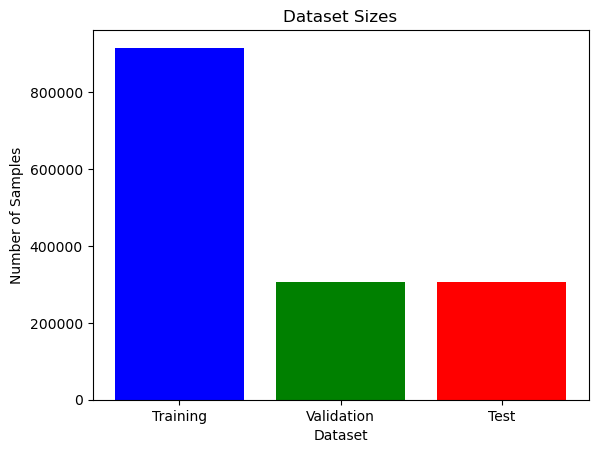

In [15]:
# Volume of data
import matplotlib.pyplot as plt

labels = ['Training', 'Validation', 'Test']
sizes = [base_train.shape[0], base_valid.shape[0], base_test.shape[0]]

plt.bar(labels, sizes, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()

In [16]:
base_train.groupby('target').count()['case_id'].tolist()

[887123, 28872]

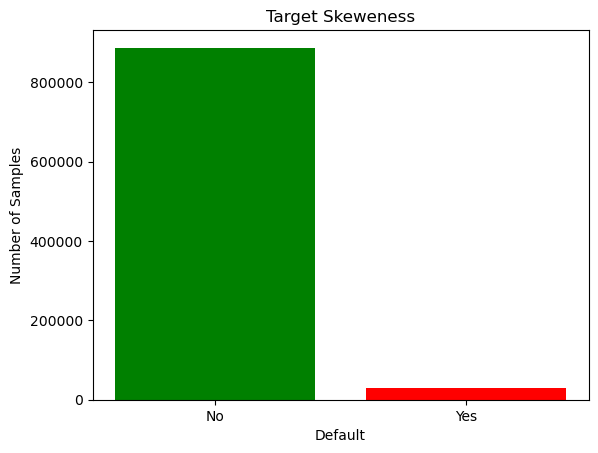

In [17]:
labels = ['No', 'Yes']
sizes = base_train.groupby('target').count()['case_id'].tolist()

plt.bar(labels, sizes, color=['green', 'red'])
plt.xlabel('Default')
plt.ylabel('Number of Samples')
plt.title('Target Skeweness')
plt.show()

Skewed dataset, 

In [18]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

# Weights for use later
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]


Number of positive samples in training data: 28872 (3.15% of total)


# Models

Set Predictions method

In [19]:
# Predictions and Evaluation

def get_pred(name,model):
    for base, X in [(base_train, X_train_1h), (base_valid, X_valid_1h), (base_test, X_test_1h)]:
        y_pred = model.predict(X)
        base["score"] = y_pred

    auc_train = roc_auc_score(base_train["target"], base_train["score"])
    auc_valid = roc_auc_score(base_valid["target"], base_valid["score"])
    auc_test = roc_auc_score(base_test["target"], base_test["score"])

    print(f'The AUC score on the train set is: {auc_train}') 
    print(f'The AUC score on the valid set is: {auc_valid}') 
    print(f'The AUC score on the test set is: {auc_test}')  
    
    stability_score_train = gini_stability(base_train)
    stability_score_valid = gini_stability(base_valid)
    stability_score_test = gini_stability(base_test)
    
    print(f'The stability score on the train set is: {stability_score_train}') 
    print(f'The stability score on the valid set is: {stability_score_valid}') 
    print(f'The stability score on the test set is: {stability_score_test}') 

    df = pd.DataFrame({
        "Model": name,
        "AUC_Train": auc_train,
        "AUC_Valid": auc_valid,
        "AUC_Test": auc_test,
        "Stability Score Train": stability_score_train,
        "Stability Score Valid": stability_score_valid,
        "Stability Score Test": stability_score_test
    }, index=[0])
    return(df)

    

In [20]:
display(X_train.head())
print(X_train.dtypes)

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,NaN,1917.6,0.0,NaN,NaN,NaN,NaN,30000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,4937.0,0.0,NaN,NaN,NaN,NaN,78000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3600.0,0.0,NaN,NaN,NaN,NaN,60000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3110.8,0.0,NaN,NaN,NaN,NaN,20000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1218.0,0.0,NaN,NaN,NaN,NaN,20300.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


amtinstpaidbefduel24m_4187115A      float64
annuity_780A                        float64
annuitynextmonth_57A                float64
avginstallast24m_3658937A           float64
avglnamtstart24m_4525187A           float64
avgoutstandbalancel6m_4187114A      float64
avgpmtlast12m_4525200A              float64
credamount_770A                     float64
currdebt_22A                        float64
currdebtcredtyperange_828A          float64
disbursedcredamount_1113A           float64
downpmt_116A                        float64
inittransactionamount_650A          float64
lastapprcommoditycat_1041M         category
lastapprcommoditytypec_5251766M    category
lastapprcredamount_781A             float64
lastcancelreason_561M              category
lastotherinc_902A                   float64
lastotherlnsexpense_631A            float64
lastrejectcommoditycat_161M        category
lastrejectcommodtypec_5251769M     category
lastrejectcredamount_222A           float64
lastrejectreason_759M           

## Pre-process features for SKLearn

In [21]:
# Fill NAs

numeric_columns = X_train.select_dtypes(include=['number']).columns
X_train[numeric_columns] = X_train[numeric_columns].fillna(0)
X_valid[numeric_columns] = X_valid[numeric_columns].fillna(0)
X_test[numeric_columns] = X_test[numeric_columns].fillna(0)

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = X_train.select_dtypes(include=['number']).columns # List of numerical feature column names
categorical_features = X_train.select_dtypes(include=['category']).columns # List of categorical feature column names

# Define preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the entire dataset
X_train_1h = preprocessor.fit_transform(X_train)
X_valid_1h = preprocessor.transform(X_valid)
X_test_1h = preprocessor.transform(X_test)

X_train_1h.shape, X_valid_1h.shape, X_test_1h.shape

((915995, 826), (305332, 826), (305332, 826))

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(random_state=42)

logr.fit(X_train_1h,y_train)



/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [24]:
logistic_regression_results = get_pred('Logistic Regression', logr)

The AUC score on the train set is: 0.5003247843885953
The AUC score on the valid set is: 0.5002242188003181
The AUC score on the test set is: 0.5005242112040815
The stability score on the train set is: -0.0001361315617912292
The stability score on the valid set is: -0.0005807936602557
The stability score on the test set is: -0.0009350378137794547


In [25]:
#y_pred = logr.predict(X_test_1h)

# Predictions and Evaluation

for base, X in [(base_train, X_train_1h), (base_valid, X_valid_1h), (base_test, X_test_1h)]:
    y_pred = logr.predict(X)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The AUC score on the train set is: 0.5003247843885953
The AUC score on the valid set is: 0.5002242188003181
The AUC score on the test set is: 0.5005242112040815
The stability score on the train set is: -0.0001361315617912292
The stability score on the valid set is: -0.0005807936602557
The stability score on the test set is: -0.0009350378137794547


Confusion Matrix:


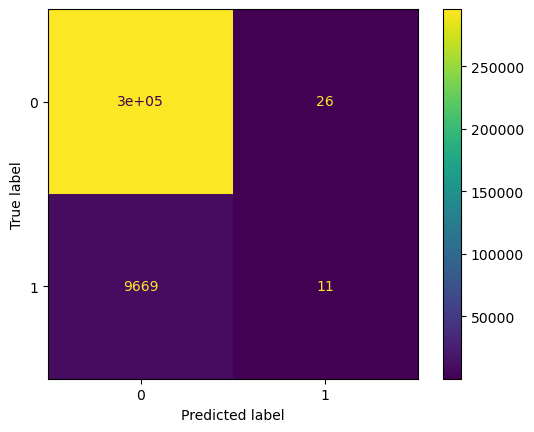

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(base_test["target"], base_test["score"])
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_).plot()



## Decision Tree

In [27]:
%%time
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train_1h,y_train)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


DecisionTreeClassifier()

In [28]:
# Predictions and Evaluation

decision_tree_results = get_pred('Decision Tree', DecisionTree)

The AUC score on the train set is: 0.9933996574081453
The AUC score on the valid set is: 0.521502523568869
The AUC score on the test set is: 0.5224597654904308
The stability score on the train set is: 0.9853871025890872
The stability score on the valid set is: 0.02143768963361438
The stability score on the test set is: 0.028595184363703327


## Deep Neural Network With Keras

### First NN Model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_features = X_train_1h.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-23 21:29:03.134743: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-23 21:29:03.134840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-23 21:29:03.134845: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-23 21:29:03.135023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-23 21:29:03.135189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Cre

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        52,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,153 (223.25 KB)

 Trainable params: 57,153 (223.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_1h, y_train, epochs=10, batch_size=2048, validation_data=(X_valid_1h, y_valid))

loss, accuracy = model.evaluate(X_test_1h, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 6.91 µs
Epoch 1/10


2024-04-23 21:29:05.378085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9413 - loss: 0.2059 - val_accuracy: 0.9691 - val_loss: 0.1274
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9685 - loss: 0.1291 - val_accuracy: 0.9691 - val_loss: 0.1265
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9683 - loss: 0.1285 - val_accuracy: 0.9691 - val_loss: 0.1262
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9685 - loss: 0.1271 - val_accuracy: 0.9691 - val_loss: 0.1264
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9686 - loss: 0.1263 - val_accuracy: 0.9691 - val_loss: 0.1258
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9684 - loss: 0.1260 - val_accuracy: 0.9691 - val_loss: 0.1258
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9682 - loss: 0.1260 - val_accuracy: 0.9691 - val_loss: 0.1259
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9687 - loss: 0.1240 - val_accurac

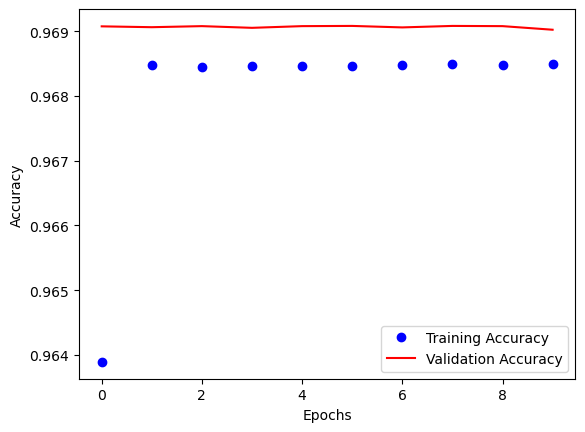

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(10) # 50 is the number of epochs
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
print('The Results of Model 1 are')
nn1_results = get_pred('Neural Network 1', model)

The Results of Model 1 are
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
The AUC score on the train set is: 0.7789089492236392
The AUC score on the valid set is: 0.7393607135685889
The AUC score on the test set is: 0.7361796193086847
The stability score on the train set is: 0.5350667471701618
The stability score on the valid set is: 0.4389300067889802
The stability score on the test set is: 0.42869751752669805


In [33]:
model.save("home_credit_nn1.keras")

### Second NN Model

In [34]:
from tensorflow.keras.layers import Input, Dropout, BatchNormalization

model2 = Sequential(
    [
        Input(shape=(num_features,)),
        Dense(256, activation="relu"),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       211,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,553 (1.31 MB)

 Trainable params: 343,553 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
%%time
from tensorflow.keras.optimizers import Adam

epochs = 30

model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy','precision','recall'])

class_weight = {0: weight_for_0, 1: weight_for_1}

history2 = model2.fit(X_train_1h, y_train, epochs=epochs, batch_size=2048, validation_data=(X_valid_1h, y_valid),class_weight=class_weight)

loss, accuracy, precision, recall = model2.evaluate(X_test_1h, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.6195 - loss: 1.5060e-06 - precision: 0.0331 - recall: 0.4015 - val_accuracy: 0.6358 - val_loss: 0.6761 - val_precision: 0.0506 - val_recall: 0.6067
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.6203 - loss: 1.4639e-06 - precision: 0.0486 - recall: 0.5886 - val_accuracy: 0.6755 - val_loss: 0.6467 - val_precision: 0.0556 - val_recall: 0.5937
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.6584 - loss: 1.3968e-06 - precision: 0.0541 - recall: 0.6017 - val_accuracy: 0.6812 - val_loss: 0.6223 - val_precision: 0.0581 - val_recall: 0.6119
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.6511 - loss: 1.3785e-06 - precision: 0.0564 - recall: 0.6377 - val_accuracy: 0.6327 - val_loss: 0.6346 - val_precision: 0.0558 - val_recall: 0.6829
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.6388 - loss: 1.3575e-06 - precision: 0.0560 - recall: 0.6630 - val_a

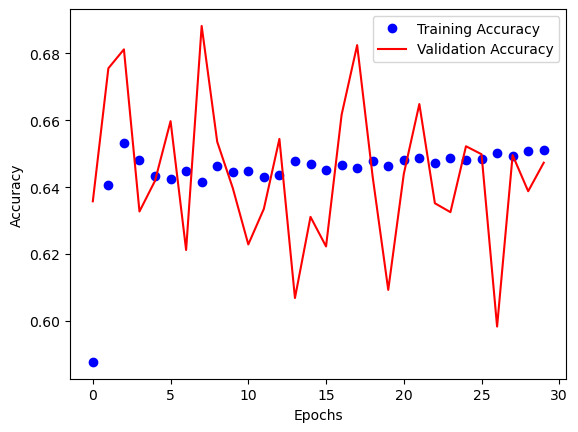

In [36]:

train_acc = history2.history['accuracy']
valid_acc = history2.history['val_accuracy']
plt.plot(range(epochs), train_acc, 'bo', label='Training Accuracy')
plt.plot(range(epochs), valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
print('The Results of Model 2 are')
nn2_results = get_pred('Neural Network 2', model2)

The Results of Model 2 are
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 110s 4ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step
The AUC score on the train set is: 0.7567563649875022
The AUC score on the valid set is: 0.7466230195949566
The AUC score on the test set is: 0.7428564069852953
The stability score on the train set is: 0.4818368463695506
The stability score on the valid set is: 0.4617991560727842
The stability score on the test set is: 0.44834076597851913


In [38]:
model2.save("home_credit_nn2.keras")

### Evaluation Comparison

In [39]:
dfs = [results, logistic_regression_results, decision_tree_results, nn1_results, nn2_results]

# Concatenate the DataFrames
results = pd.concat(dfs, ignore_index=True)

In [40]:
results

,Model,AUC_Train,AUC_Valid,AUC_Test,Stability Score Train,Stability Score Valid,Stability Score Test
0,Light GBM,0.764123,0.751216,0.748307,0.497665,0.472673,0.458364
1,Logistic Regression,0.500325,0.500224,0.500524,-0.000136,-0.000581,-0.000935
2,Decision Tree,0.993400,0.521503,0.522460,0.985387,0.021438,0.028595
3,Neural Network 1,0.778909,0.739361,0.736180,0.535067,0.438930,0.428698
4,Neural Network 2,0.756756,0.746623,0.742856,0.481837,0.461799,0.448341


## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

#### Load Winning Model

In [41]:
from tensorflow.keras.models import load_model
model = load_model("home_credit_nn1.keras")

In [42]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

# Fill NAs
numeric_columns = X_submission.select_dtypes(include=['number']).columns
X_submission[numeric_columns] = X_submission[numeric_columns].fillna(0)

X_submission_1h = preprocessor.transform(X_submission)

y_submission_pred = model.predict(X_submission_1h).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [43]:
y_submission_pred
#X_submission


array([0.00172501, 0.03870972, 0.0056545 , 0.00324539, 0.02992025,
       0.00410766, 0.00045688, 0.00063873, 0.02820902, 0.00664353],
      dtype=float32)

In [44]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")